In [1]:
import xarray as xr #more advanced version of pandas for playing with multiple variables(lable maker)
import pickle 
import matplotlib as plt
import os #play with your computer's file and folder 
import cartopy as cp
import geopandas as gp
import sys 
import numpy as np
import pandas as pd #read excell and csv file and play with them
import scipy as sp
import regionmask as rg
import textwrap as tp
#3a open the carbon bombs list sheet in excell
def pre_processing_carbon_bombs(excel_file):
    df = pd.read_excel(excel_file, sheet_name='Full Carbon Bombs List')
    return df 

file_name = r"C:\Users\98937\NOBY\carbon_bombs_kuhne_2022.xlsx"

print(os.path.exists(file_name))  # Just to make sure the file exist in the path

df = pre_processing_carbon_bombs(file_name)

print(df.head()) #just for check


True
   New                    Name    Country  Potential emissions (Gt CO2)  \
0    *         Tannezuft Shale    Algeria                      2.347867   
1  NaN  Hassi R'Mel (Domestic)    Algeria                      2.271542   
2  NaN          Hassi Messaoud    Algeria                      1.215923   
3  NaN       Vaca Muerta Shale  Argentina                      5.177782   
4  NaN   Red Hill Coal Project  Australia                      4.564469   

      Fuel  Unnamed: 5  Country.1  # of Carbon Bombs  Potential Emissions  \
0  Oil&Gas         NaN        NaN                NaN                  NaN   
1  Oil&Gas         NaN        NaN                NaN                  NaN   
2  Oil&Gas         NaN    Algeria                3.0             5.835333   
3  Oil&Gas         NaN  Argentina                1.0             5.177782   
4     Coal         NaN        NaN                NaN                  NaN   

   Rank           Country.2  # of Carbon Bombs.1  Potential Emissions.1  \
0   1.

In [2]:
#3b keping only the columns that we need 
df = df[["New", "Name", "Country", "Potential emissions (Gt CO2)", "Fuel"]] 
print(df.head())

   New                    Name    Country  Potential emissions (Gt CO2)  \
0    *         Tannezuft Shale    Algeria                      2.347867   
1  NaN  Hassi R'Mel (Domestic)    Algeria                      2.271542   
2  NaN          Hassi Messaoud    Algeria                      1.215923   
3  NaN       Vaca Muerta Shale  Argentina                      5.177782   
4  NaN   Red Hill Coal Project  Australia                      4.564469   

      Fuel  
0  Oil&Gas  
1  Oil&Gas  
2  Oil&Gas  
3  Oil&Gas  
4     Coal  


In [3]:
#3c converting potential column to float
df = df.copy() # i made a copy because i got a warning i asked chatgpt and found i can fix it this way
df["Potential emissions (Gt CO2)"] = pd.to_numeric(df["Potential emissions (Gt CO2)"], errors='coerce') #convert everything in that colomn to number and if its not posible replace it with NaN
print(df["Potential emissions (Gt CO2)"].head) #just to see if its work


<bound method NDFrame.head of 0         2.347867
1         2.271542
2         1.215923
3         5.177782
4         4.564469
          ...     
424       1.000000
425    1182.272634
426     646.027060
427     536.245575
428     419.044522
Name: Potential emissions (Gt CO2), Length: 429, dtype: float64>


In [4]:
#3d create new column
def check_New(x):
    x = str(x).strip()
    if x == "*":
        return 1
    else:
        return 0
df["new"] = df["New"].apply(check_New)  
print(df["new"].head()) 

0    1
1    0
2    0
3    0
4    0
Name: new, dtype: int64


In [5]:
#3e name as an index so we can refer to rows by their name
df = df.set_index("Name")
print(df.head())

                        New    Country  Potential emissions (Gt CO2)     Fuel  \
Name                                                                            
Tannezuft Shale           *    Algeria                      2.347867  Oil&Gas   
Hassi R'Mel (Domestic)  NaN    Algeria                      2.271542  Oil&Gas   
Hassi Messaoud          NaN    Algeria                      1.215923  Oil&Gas   
Vaca Muerta Shale       NaN  Argentina                      5.177782  Oil&Gas   
Red Hill Coal Project   NaN  Australia                      4.564469     Coal   

                        new  
Name                         
Tannezuft Shale           1  
Hassi R'Mel (Domestic)    0  
Hassi Messaoud            0  
Vaca Muerta Shale         0  
Red Hill Coal Project     0  


In [6]:
#3f convert df to a certain dataset(ds)
#xarray ba ye moteghayer va dade on moteghayer tarif mishe ma ghblan name ro index kardim yani mitonim alan as name va tabe harkodom azon moteghayera estefade konim bara list kardan moteghayer vali in name feghat bara adress dadan va peyda kardan adad estefade mishe 
#removing some unnesesory data because its going to make us some problem later
df = df[df["Country"].notna()]
#building dataset
ds_carbon_bombs = xr.Dataset(
    coords=dict(
        name=df.index.values,                   # project names that we set as an index for df previously
        country=(["name"], df["Country"].values),  # country of each project (index,value)
        fuel=(["name"], df["Fuel"].values)         # fuel type
    )
)
#add variables
ds_carbon_bombs["potential_emissions"] = (["name"], df["Potential emissions (Gt CO2)"].values)
ds_carbon_bombs["new"] = (["name"], df["new"].values)
ds_carbon_bombs["total"] = (["name"], df["Potential emissions (Gt CO2)"].values)
#when i try to write this part with if/else i got confused asked Chatgpt and found this beutiful function(lambda)
ds_carbon_bombs["total_oil_and_gas"] = (["name"], df.apply(
    lambda r: r["Potential emissions (Gt CO2)"] if r["Fuel"] =="Oil&Gas" else 0,axis=1).values)

ds_carbon_bombs["total_coal"] = (["name"], df.apply(
    lambda r: r["Potential emissions (Gt CO2)"] if r["Fuel"] == "Coal" else 0,axis=1).values)

ds_carbon_bombs["total_new_carbon_bombs"] = (["name"], df.apply(
    lambda r: r["Potential emissions (Gt CO2)"] if r["new"] == 1 else 0,axis=1).values)

#define attributes (this step is just to help reading and understandin the dataset

ds_carbon_bombs.attrs["description"] = "Processed carbon bomb dataset from Kühne et al. (2022)"
ds_carbon_bombs.attrs["units"] = "GtCO2"

ds_carbon_bombs["potential_emissions"].attrs["description"] = "Potential CO2 emissions for each project"
ds_carbon_bombs["new"].attrs["description"] = "Indicator: 1 if new project, 0 otherwise"
ds_carbon_bombs["total_oil_and_gas"].attrs["description"] = "Emissions from oil and gas only"
ds_carbon_bombs["total_coal"].attrs["description"] = "Emissions from coal only"
ds_carbon_bombs["total_new_carbon_bombs"].attrs["description"] = "Emissions from new carbon bombs"


 #Save the dataset as pickle

with open("ds_carbon_bombs.pkl", "wb") as f:
    pickle.dump(ds_carbon_bombs, f)

print(ds_carbon_bombs) # just for check


<xarray.Dataset> Size: 31kB
Dimensions:                 (name: 425)
Coordinates:
  * name                    (name) object 3kB 'Tannezuft Shale' ... 'Sengwe C...
    country                 (name) object 3kB 'Algeria' 'Algeria' ... 'Zimbabwe'
    fuel                    (name) object 3kB 'Oil&Gas' 'Oil&Gas' ... 'Coal'
Data variables:
    potential_emissions     (name) float64 3kB 2.348 2.272 1.216 ... 1.091 1.0
    new                     (name) int64 3kB 1 0 0 0 0 1 0 0 ... 0 1 1 1 1 0 1 0
    total                   (name) float64 3kB 2.348 2.272 1.216 ... 1.091 1.0
    total_oil_and_gas       (name) float64 3kB 2.348 2.272 1.216 ... 1.091 0.0
    total_coal              (name) float64 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 1.0
    total_new_carbon_bombs  (name) float64 3kB 2.348 0.0 0.0 ... 0.0 1.091 0.0
Attributes:
    description:  Processed carbon bomb dataset from Kühne et al. (2022)
    units:        GtCO2


<xarray.DataArray 'potential_emissions' (name: 20)> Size: 160B
array([27.80443109, 26.71441286, 19.22190525, 16.62881821, 16.03032948,
       13.6884891 , 13.20413118, 11.92614355, 11.61275076, 11.15863625,
        9.5482279 ,  9.003555  ,  8.97193968,  8.89417848,  8.8637937 ,
        8.84382183,  8.4833496 ,  8.34191901,  7.99347107,  7.83946416])
Coordinates:
  * name     (name) object 160B 'Permian Delaware Tight' ... 'Jiangjun Gebi N...
    country  (name) object 160B 'United States' 'United States' ... 'China'
    fuel     (name) object 160B 'Oil&Gas' 'Oil&Gas' 'Oil&Gas' ... 'Coal' 'Coal'
Attributes:
    description:  Potential CO2 emissions for each project


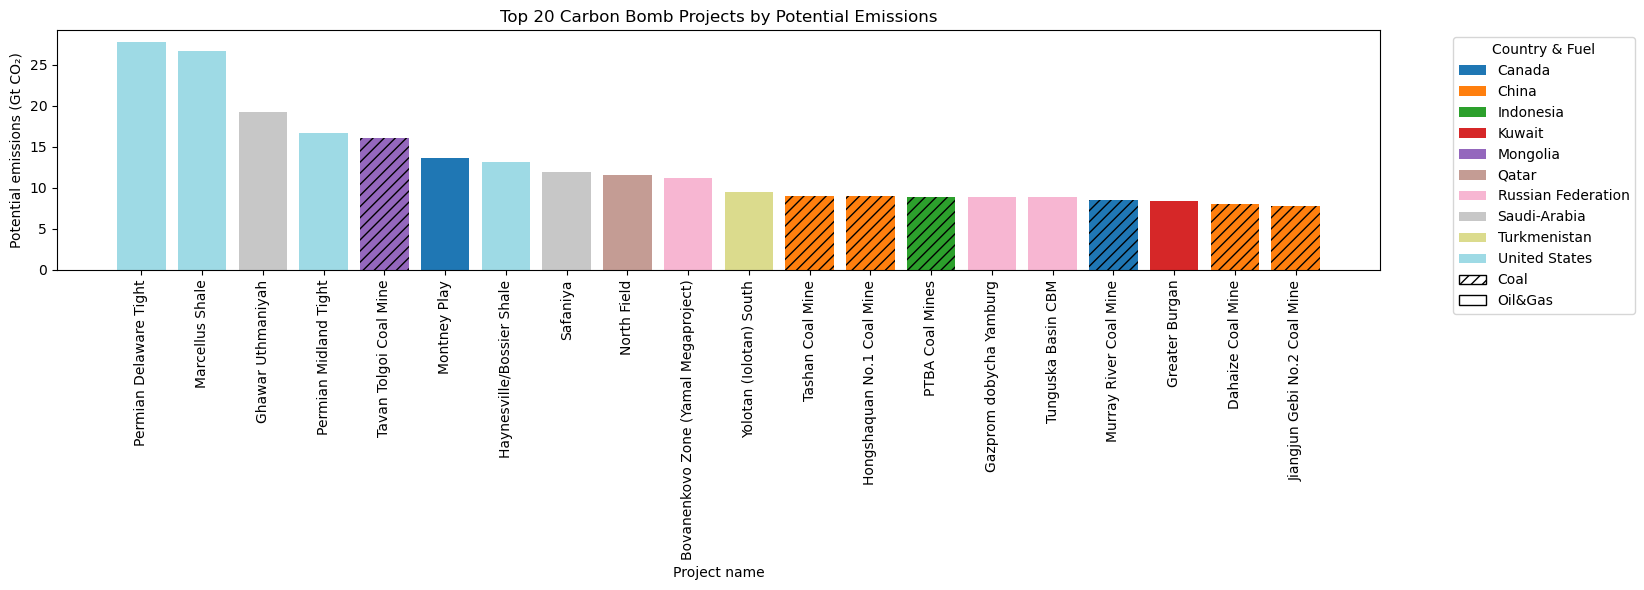

In [7]:
#4
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
#since in excell file we have cells with total amount of potentiall emition we nedd to first delete
#unnececery data and its easier to do it at the bigining before creating dataset
top20 = (
    ds_carbon_bombs
    .sortby("potential_emissions", ascending=False)
    .isel(name=slice(0, 20))
)

print(top20["potential_emissions"]) #just for check with excell file:)

names = top20.name.values
emissions = top20["potential_emissions"].values
countries = top20["country"].values
fuels = top20["fuel"].values
import matplotlib.pyplot as plt
import numpy as np

unique_countries = np.unique(countries)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_countries)))

country_color_map = dict(zip(unique_countries, colors))
bar_colors = [country_color_map[c] for c in countries]
fuel_hatch_map = {
    "Coal": "///",
    "Oil&Gas": "",
}

bar_hatches = [fuel_hatch_map.get(f, "") for f in fuels]
plt.figure(figsize=(14, 6))

bars = plt.bar(names, emissions, color=bar_colors)

# Apply hatches
for bar, hatch in zip(bars, bar_hatches):
    bar.set_hatch(hatch)

plt.xticks(rotation=90)
plt.ylabel("Potential emissions (Gt CO₂)")
plt.xlabel("Project name")
plt.title("Top 20 Carbon Bomb Projects by Potential Emissions")
plt.tight_layout()

# Legend for countries (color)
country_patches = [Patch(facecolor=color, label=country) for country, color in country_color_map.items()]

# Legend for fuels (hatch)
fuel_patches = [Patch(facecolor='white', hatch=hatch, label=fuel, edgecolor='black') 
                for fuel, hatch in fuel_hatch_map.items()]

# Combine legends
plt.legend(handles=country_patches + fuel_patches, title="Country & Fuel", 
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



In [46]:
#task5
#Load the dataset by region
with open("ds_Carbon_Bombs_Permian_Delaware_Tight_all_hazards_all_regions.pkl", "rb") as f:
    ds_regions = pickle.load(f)

# Load the dataset by country
with open("ds_Carbon_Bombs_Permian_Delaware_Tight_all_hazards_all_countries.pkl", "rb") as f:
    ds_countries = pickle.load(f)
    print("Regions dataset:")
print(ds_regions)
#print(ds_regions.data_vars) #just to have a better view of data

print("\nCountries dataset:")
#print(ds_countries)
#print(ds_countries["extreme"])
print(ds_countries.data_vars) #just to have better view of data

Regions dataset:
<xarray.Dataset> Size: 41MB
Dimensions:                  (project: 1, extreme: 6, region: 12, samples: 70000)
Coordinates:
  * project                  (project) object 8B 'Permian Delaware Tight'
  * extreme                  (extreme) object 48B 'burntarea' ... 'tropicalcy...
  * region                   (region) object 96B 'East Asia & Pacific' ... 'W...
  * samples                  (samples) int64 560kB 0 1 2 3 ... 69997 69998 69999
Data variables: (12/13)
    S2S_LH_results           (project, extreme, region, samples) float64 40MB ...
    mean_val                 (project, extreme, region) float64 576B 1.884e+0...
    std_val                  (project, extreme, region) float64 576B 2.595e+0...
    median_val               (project, extreme, region) float64 576B 2.716e+0...
    ci_lower                 (project, extreme, region) float64 576B 0.0 ... 0.0
    ci_upper                 (project, extreme, region) float64 576B 7.321e+0...
    ...                       ..

In [40]:
#just to see what type of data we have in gdf_country_borders
import pickle
import geopandas as gpd
import pickle

with open("gdf_country_borders.pkl", "rb") as f:
    gdf_country_borders = pickle.load(f)
#just for solving error at futuere steps
with open("gdf_country_borders_new.pkl", "wb") as f:
    pickle.dump(gdf_country_borders, f)

print(gdf_country_borders)

                                                               geometry  \
name                                                                      
Afghanistan           POLYGON ((71.0498 38.40866, 71.05714 38.40903,...   
Angola                MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...   
Albania               POLYGON ((19.74777 42.5789, 19.74601 42.57993,...   
United Arab Emirates  MULTIPOLYGON (((53.86305 24.23469, 53.8886 24....   
Argentina             MULTIPOLYGON (((-68.65412 -54.88624, -68.65414...   
...                                                                 ...   
Samoa                 MULTIPOLYGON (((-171.57002 -13.93816, -171.564...   
Yemen                 MULTIPOLYGON (((53.30824 12.11839, 53.31027 12...   
South Africa          MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -...   
Zambia                POLYGON ((31.11984 -8.61663, 31.14102 -8.60619...   
Zimbabwe              POLYGON ((30.01065 -15.64623, 30.05024 -15.640...   

                        

C:\Users\98937\AppData\Local\Temp\ipykernel_15072\1950151170.py:7: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  gdf_country_borders = pickle.load(f)


<xarray.DataArray 'mean_val' (region: 12)> Size: 96B
array([ 579327.68701127,  287384.89019958,  339824.20170358,
        286282.1184013 ,  592424.36391807, 1330924.78408477,
        303756.05029139,  124304.0111909 ,  673990.96566734,
        820670.28260976,  799986.67444312, 3059608.72612967])
Coordinates:
  * region   (region) object 96B 'East Asia & Pacific' ... 'World'


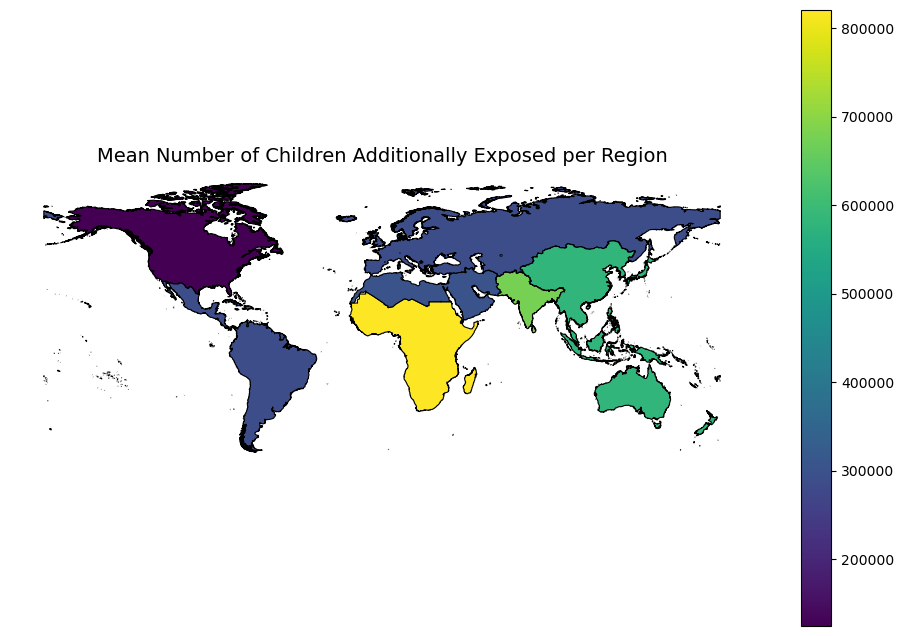

In [55]:
#task 6
import pickle
import geopandas as gpd
import matplotlib.pyplot as plt
# first creat geodataframe for regions
import geopandas as gpd
from shapely.ops import unary_union

# Parameters
project_crs = "EPSG:3857"  # projected CRS for accurate geometry operations
tol_meters = 100           # small buffer to remove gaps

# List to store region geometries
regional_geoms = []

# Loop over unique regions
for region_name in gdf_country_borders['region'].unique():
    # Select countries in this region
    subset = gdf_country_borders[gdf_country_borders['region'] == region_name].copy()
    if subset.empty:
        continue

    # Reproject to planar CRS for accurate union
    subset_proj = subset.to_crs(project_crs)
    # Fix invalid geometries
    subset_proj['geometry'] = subset_proj['geometry'].buffer(0)

    # Merge all country polygons in the region
    geoms = list(subset_proj.geometry)
    if len(geoms) == 1:
        union = geoms[0]
    else:
        # Optional: buffer-expand and buffer-shrink to remove tiny gaps
        buffered_pos = [g.buffer(tol_meters) for g in geoms]
        union_pos = unary_union(buffered_pos)
        union = union_pos.buffer(-tol_meters)
    # Clean union
    union = union.buffer(0)

    # Append to list
    regional_geoms.append({'region': region_name, 'geometry': union})

# Build GeoDataFrame for regions
gdf_regions_border = gpd.GeoDataFrame(regional_geoms, crs=project_crs)
# Convert back to original CRS for plotting
gdf_regions_border = gdf_regions_border.to_crs(gdf_country_borders.crs)

#print(gdf_regions_border) #just for check
# in dataset we have mean_val for 6 different extreme if we want to include all of this extreme we only can 
#average the data because its not make sence to a average over extreme
ds_region_mean = ds_regions["mean_val"].mean(dim=["extreme","project"])
print(ds_region_mean)
#we can see the plot for every selected hazard
#ds_region_mean = ds_regions["mean_val"].sel(extreme=["heatwavedarea"]) #i didnt change the name so dont have to change the code
#print(ds_region_mean) #just check
# we have to merge this two together wich is impossible for dataset so convert to dataframe
df_region_mean = ds_region_mean.to_dataframe().reset_index()
#print(df_region_mean.head())
gdf_regions_border = gdf_regions_border.merge(
    df_region_mean,
    on="region",
    how="left"
)
#print(gdf_regions_border)
# Plotting function (i used chatgpt for this part to have a nicer plot)
def plot_mean_exposure_by_region(gdf_regions_border):
    fig, ax = plt.subplots(figsize=(12, 8))

    gdf_regions_border.plot(
        column="mean_val",
        cmap="viridis",
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        ax=ax
    )

    ax.set_title(
        "Mean Number of Children Additionally Exposed per Region",
        fontsize=14
    )

    ax.set_axis_off()
    plt.show()
plot_mean_exposure_by_region(gdf_regions_border)



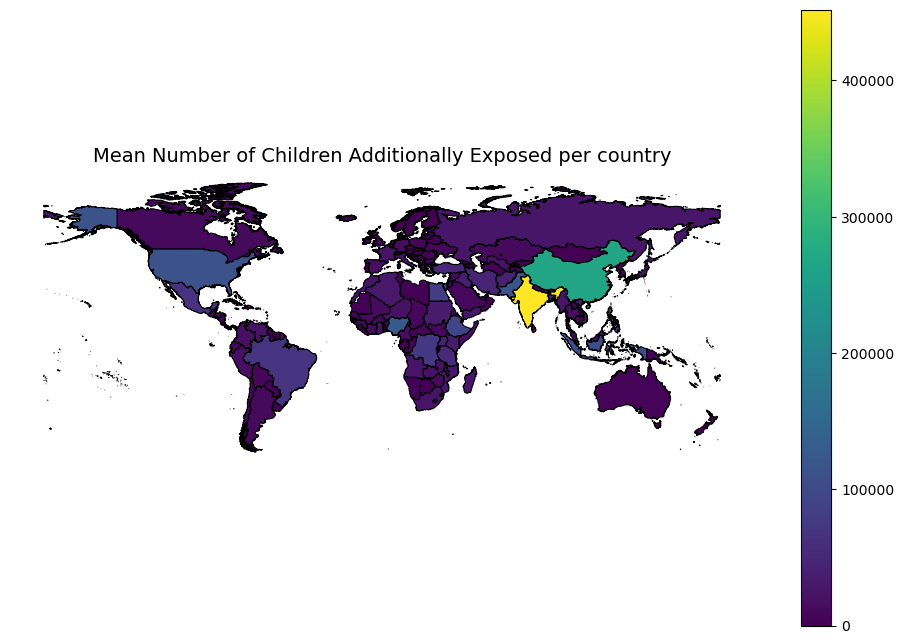

In [43]:
#task7
import pickle
import geopandas as gpd
import matplotlib.pyplot as plt
#its almost same as task6 the only diference is we have name instead of country in pickle file
#its easier to change the dataframe to make them same and then we can merge
ds_country_mean = ds_countries["mean_val"].mean(dim=[ "extreme"])
df_country_mean = ds_country_mean.to_dataframe().reset_index()
df_country_mean.rename(columns={"country": "name"}, inplace=True)
#print(df_country_mean.head())

gdf_country_border = (gdf_country_borders.reset_index())
gdf_country_border = gdf_country_border.merge(
    df_country_mean,
    on="name",
    how="left"
)
#print(gdf_country_border)
# Plotting function (i used chatgpt for this part to have a nicer plot)
def plot_mean_exposure_by_country(gdf_country_border):
    fig, ax = plt.subplots(figsize=(12, 8))

    gdf_country_border.plot(
        column="mean_val",
        cmap="viridis",
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        ax=ax
    )

    ax.set_title(
        "Mean Number of Children Additionally Exposed per country",
        fontsize=14
    )

    ax.set_axis_off()
    plt.show()
plot_mean_exposure_by_country(gdf_country_border)



                        region      mean_val      ci_lower      ci_upper
0          East Asia & Pacific  5.793277e+05  2.662313e+05  9.798622e+05
1        Europe & Central Asia  2.873849e+05  1.383671e+05  4.924513e+05
2                  High income  3.398242e+05  1.877022e+05  5.295001e+05
3    Latin America & Caribbean  2.862821e+05  1.433404e+05  4.727612e+05
4                   Low income  5.924244e+05  3.147117e+05  9.399195e+05
5          Lower middle income  1.330925e+06  6.819128e+05  2.131512e+06
6   Middle East & North Africa  3.037561e+05  1.535651e+05  5.303385e+05
7                North America  1.243040e+05  6.207133e+04  2.320757e+05
8                   South Asia  6.739910e+05  3.165444e+05  1.250477e+06
9           Sub-Saharan Africa  8.206703e+05  4.282079e+05  1.291659e+06
10         Upper middle income  7.999867e+05  3.698780e+05  1.327102e+06
11                       World  3.059609e+06  1.672958e+06  4.720078e+06
                       region  \
0                 

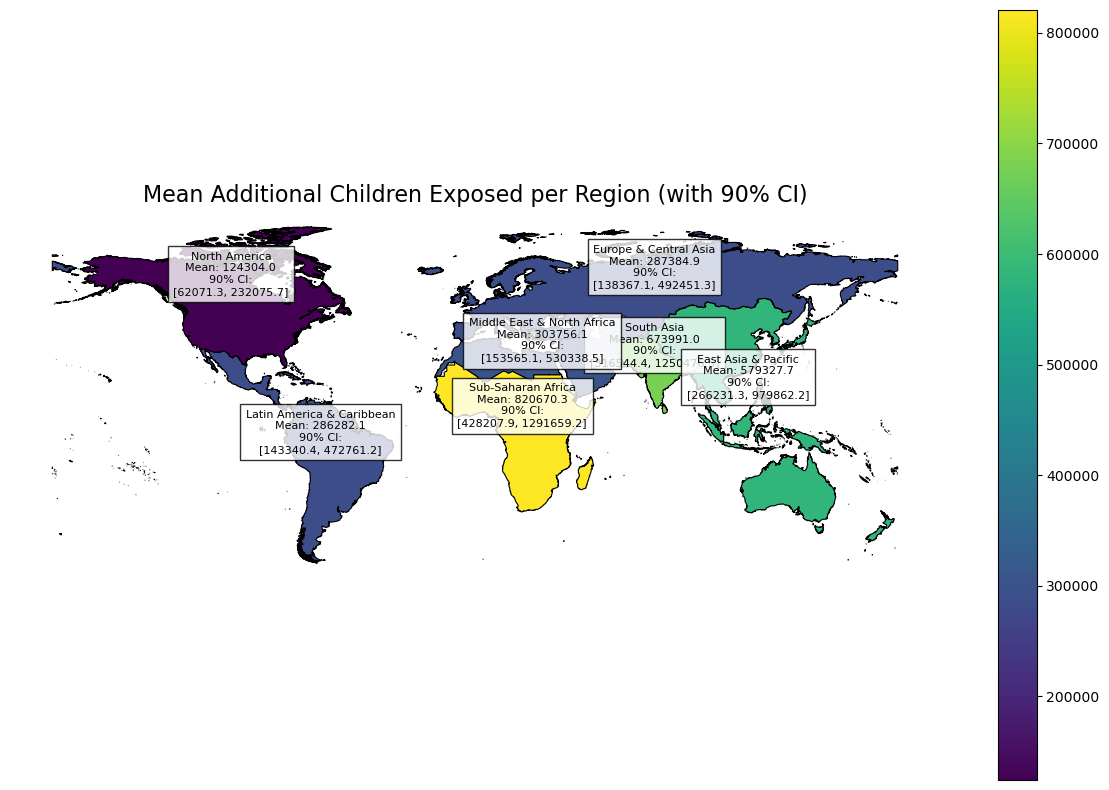

In [60]:
#task8 & 9
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

#  Extract only required variables and convert them to dataframe
ds_regions_select = ds_regions[["mean_val", "ci_lower", "ci_upper"]]

ds_regions_select_mean = ds_regions_select.mean(dim=["extreme","project"])
df_regions = ds_regions_select_mean.to_dataframe().reset_index()
df_regions = df_regions[['region', 'mean_val', 'ci_lower', 'ci_upper']]

print(df_regions)
#now merge it with region border
gdf_regions_border = gdf_regions_border.drop(columns=['mean_val', 'ci_lower', 'ci_upper'], errors='ignore')

gdf_regions_CI = gdf_regions_border.merge(df_regions,on="region",how="left")
print(gdf_regions_CI)

# REGION MAP WITH CI BOXES (UPDATED TO SAVE)
def plot_regions_with_ci(gdf):
    fig, ax = plt.subplots(figsize=(15, 10))

    gdf.plot(
        column="mean_val",
        cmap="viridis",
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        ax=ax
    )

    #  CI BOX FOR EACH REGION
    for _, row in gdf.iterrows():
        if not np.isnan(row["mean_val"]):
            # Suppress GeoPandas warning by using .coords[0] directly
            x, y = row.geometry.centroid.coords[0] 
            label = (
                f"{row['region']}\n"
                f"Mean: {row['mean_val']:.1f}\n"
                f"90% CI:\n[{row['ci_lower']:.1f}, {row['ci_upper']:.1f}]"
            )
            ax.text(
                x, y, label,
                ha="center",
                fontsize=8,
                bbox=dict(facecolor="white", alpha=0.8)
            )

    ax.set_title("Mean Additional Children Exposed per Region (with 90% CI)", fontsize=16)
    ax.set_axis_off()
   
    # === SAVE COMMAND FOR REGIONAL FIGURE ===
    plt.savefig('region_ci_map.png', dpi=300, bbox_inches='tight')
    # ========================================
   
    plt.show()
plot_regions_with_ci(gdf_regions_CI)



       
  



              name                                           geometry  \
71           India  MULTIPOLYGON (((93.85532 7.21418, 93.865 7.200...   
28           China  MULTIPOLYGON (((111.2046 15.77924, 111.19654 1...   
114        Nigeria  MULTIPOLYGON (((7.45191 4.47553, 7.46957 4.471...   
121       Pakistan  MULTIPOLYGON (((67.47779 24.05121, 67.48536 24...   
165  United States  MULTIPOLYGON (((-155.60652 20.13796, -155.5863...   
10         Belgium  POLYGON ((4.81545 51.43107, 4.82268 51.41368, ...   

                    region                 project       mean_val  \
71              South Asia  Permian Delaware Tight  451923.676879   
28     East Asia & Pacific  Permian Delaware Tight  265526.601032   
114     Sub-Saharan Africa  Permian Delaware Tight  127081.586257   
121             South Asia  Permian Delaware Tight  119449.521628   
165          North America  Permian Delaware Tight  114080.500259   
10   Europe & Central Asia  Permian Delaware Tight    2004.747975   

    

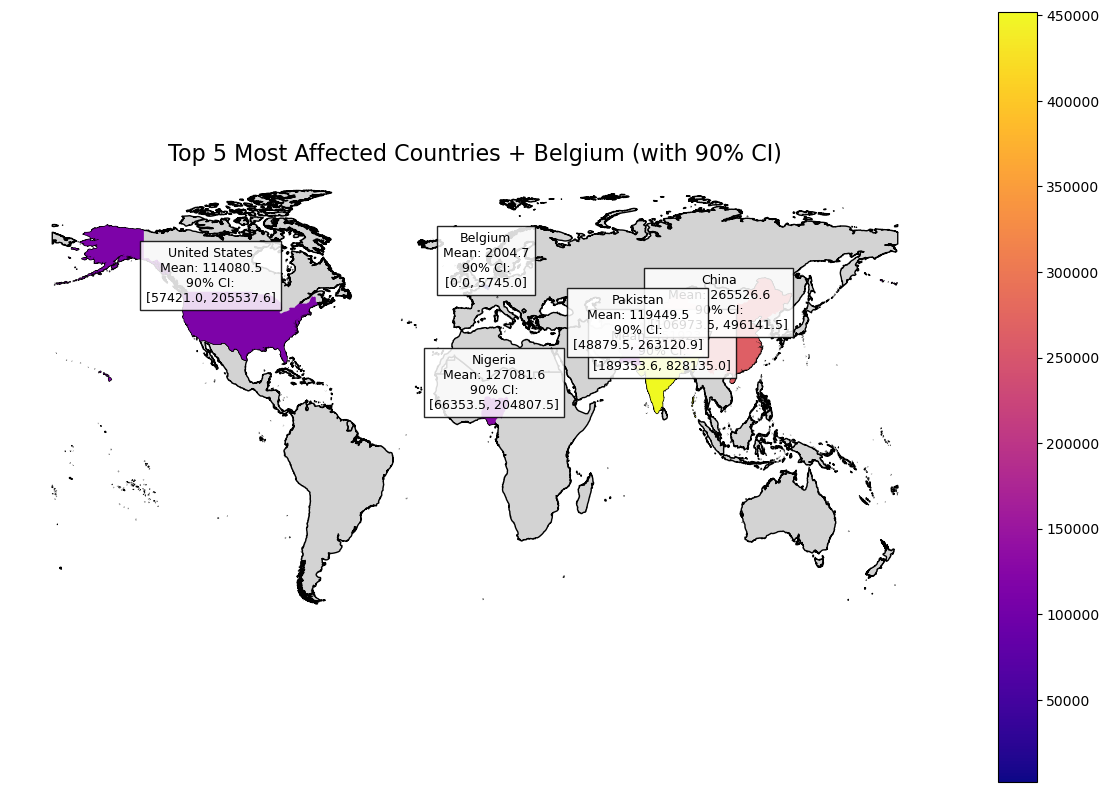

<Figure size 640x480 with 0 Axes>

In [63]:

# COUNTRY-LEVEL (TOP 5 + BELGIUM) 


#  Extract only required country variables and convert to dataframe
ds_cty_small = ds_countries[["mean_val", "ci_lower", "ci_upper"]]

df_countries = (
    ds_cty_small
    .mean(dim=["extreme"])
    .to_dataframe()
    .reset_index()
)

# Select TOP 5 most affected countries
#top5 = df_countries.sort_values("mean_val", ascending=False).head(5)

# Add Belgium for comparison
#belgium = df_countries[df_countries["country"] == "Belgium"]

#df_plot = pd.concat([top5, belgium])

df_countries.rename(columns={"country": "name"}, inplace=True)
# merge
gdf_country_border = gdf_country_border.drop(columns=['mean_val', 'ci_lower', 'ci_upper'], errors='ignore')
gdf_country_ci = gdf_country_border.merge(
    df_countries,
    on="name",
    how="left"
)

top5 = gdf_country_ci.sort_values("mean_val", ascending=False).head(5)
belgium = gdf_country_ci[gdf_country_ci["name"] == "Belgium"]

df_plot = pd.concat([top5, belgium])
print(df_plot)

#  COUNTRY MAP WITH CI BOXES (ONLY TOP 5 + BELGIUM) (UPDATED TO SAVE)
def plot_countries_with_ci(gdf):
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot background regions
    gdf_regions_border.plot(
        color="lightgrey",
        edgecolor="black",
        ax=ax
    )

    # Plot selected countries (Using points for clear visibility over background)
    # Ensure gdf has its 'geometry' column set for plotting
    gdf.plot(
     column="mean_val",
        cmap="plasma",
        markersize=200, # Increased size for points
        marker='o',
        legend=True,
        ax=ax,
        zorder=3
    )

    # ✅ CI BOXES ONLY FOR SELECTED COUNTRIES
    for _, row in gdf.iterrows():
        x, y = row.geometry.centroid.coords[0]
        label = (
            f"{row['name']}\n"
            f"Mean: {row['mean_val']:.1f}\n"
            f"90% CI:\n[{row['ci_lower']:.1f}, {row['ci_upper']:.1f}]"
        )
        ax.text(
            x, y, label,
            ha="center",
            fontsize=9,
            bbox=dict(facecolor="white", alpha=0.85)
        )

    ax.set_title("Top 5 Most Affected Countries + Belgium (with 90% CI)", fontsize=16)
    ax.set_axis_off()
    plt.show()
  
    #  SAVE COMMAND FOR COUNTRY FIGURE 
    plt.savefig('country_ci_map.png', dpi=300, bbox_inches='tight')
plot_countries_with_ci(df_plot )
   
  

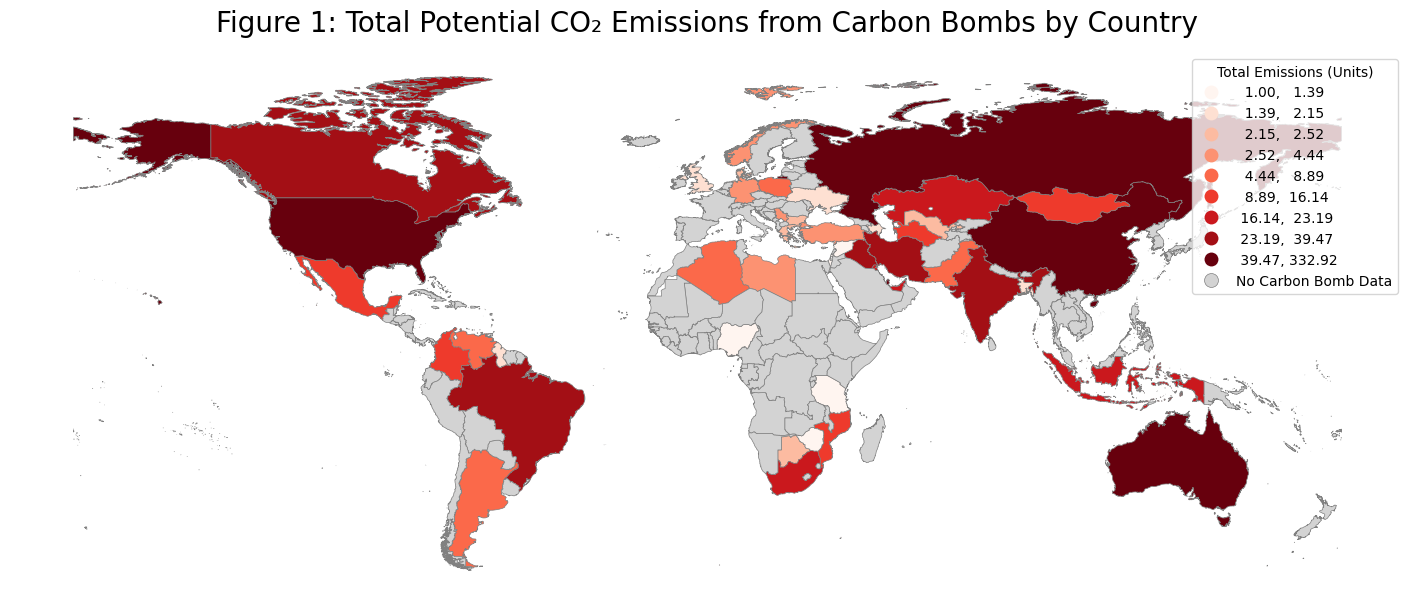

In [29]:
#task10
#first figure: we can plot total emmision per country to see Which countries are responsible for the most emissions
df_carbon_bombs=ds_carbon_bombs[["potential_emissions"]].to_dataframe().reset_index()
df_country_total = (df_carbon_bombs.groupby("country")["potential_emissions"].sum().reset_index())
df_country_total.rename(columns={"country": "name"}, inplace=True)
#print(df_country_total)
# i add this line because there was some countries with PE thta didnt show up in map
df_country_total["name"] = df_country_total["name"].str.strip().str.title()
gdf_country_border["name"] = gdf_country_border["name"].str.strip().str.title()

# merge with countryborder
gdf_emissions=gdf_country_border.merge(df_country_total,on="name",how="left")
#print(gdf_country_total)
def plot_total_emissions(gdf_emissions):
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    
    gdf_emissions.plot(
        column='potential_emissions', cmap='Reds', scheme='quantiles', k=9,
        linewidth=0.5, edgecolor='grey', legend=True, ax=ax,
        missing_kwds={"color": "lightgrey", "label": "No Carbon Bomb Data"}
    )

    ax.set_title("Figure 1: Total Potential CO₂ Emissions from Carbon Bombs by Country", fontsize=20, pad=15)
    leg = ax.get_legend()
    if leg:
        leg.set_title("Total Emissions (Units)")
    ax.set_axis_off()
    plt.savefig('figure1_total_emissions_map.png', dpi=300, bbox_inches='tight')
    plt.show()
plot_total_emissions(gdf_emissions)
#we have missing data in our dataset for some country so maybe this type of plotting is not nice for this dataset:)


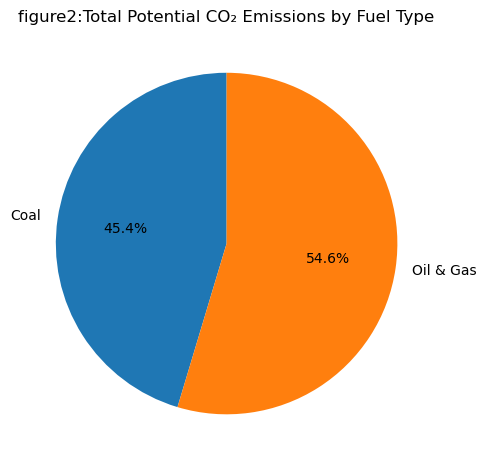

In [30]:
# figure2:lets go find out Which fuel type dominates total potential emissions
coal_total = ds_carbon_bombs["total_coal"].sum(dim="name").item()
oil_gas_total = ds_carbon_bombs["total_oil_and_gas"].sum(dim="name").item()
#print("Coal:", coal_total)
#print("Oil & Gas:", oil_gas_total)

labels = ["Coal", "Oil & Gas"]
values = [coal_total, oil_gas_total]
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))

plt.pie(
    values,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90
)

plt.title("figure2:Total Potential CO₂ Emissions by Fuel Type")
plt.tight_layout()
plt.show()


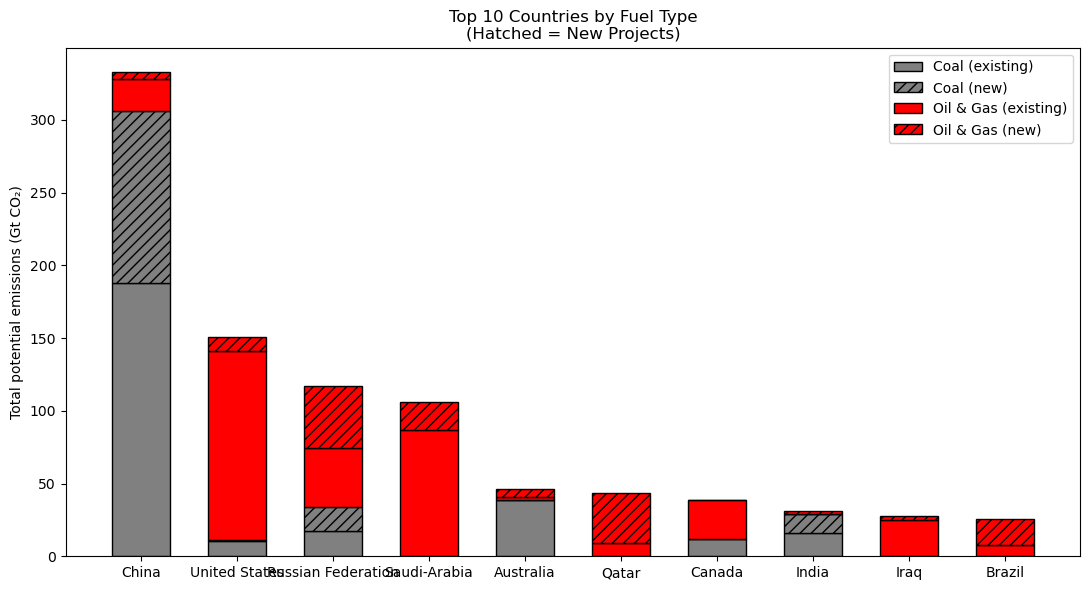

In [31]:
#figure3: Top 5 country and more:)
df = ds_carbon_bombs[["total","total_coal", "total_oil_and_gas", "total_new_carbon_bombs","new"]
].to_dataframe().reset_index()
# New coal emissions
df["new_coal"] = df.apply(
    lambda r: r["total_coal"] if r["new"] == 1 else 0,
    axis=1
)

# New oil & gas emissions
df["new_oil_gas"] = df.apply(
    lambda r: r["total_oil_and_gas"] if r["new"] == 1 else 0,
    axis=1
)

df_country = (
    df.groupby("country")[["total","total_coal", "total_oil_and_gas", "new_coal","new_oil_gas"]]
    .sum()
    .reset_index()
)

top10 = (
    df_country
    .sort_values("total", ascending=False)
    .head(10)
)
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(top10))
width = 0.6

fig, ax = plt.subplots(figsize=(11,6))

# --- Coal ---
# Old coal
ax.bar(
    x,
    top10["total_coal"] - top10["new_coal"],
    width,
    label="Coal (existing)",
    color="gray",
    edgecolor="black"
)

# New coal (hatched)
ax.bar(
    x,
    top10["new_coal"],
    width,
    bottom=top10["total_coal"] - top10["new_coal"],
    label="Coal (new)",
    color="gray",
    edgecolor="black",
    hatch="///"
)

# --- Oil & Gas ---
# Old oil & gas
ax.bar(
    x,
    top10["total_oil_and_gas"] - top10["new_oil_gas"],
    width,
    bottom=top10["total_coal"],
    label="Oil & Gas (existing)",
    color="red",
    edgecolor="black"
)

# New oil & gas (hatched)
ax.bar(
    x,
    top10["new_oil_gas"],
    width,
    bottom=top10["total_coal"] + (top10["total_oil_and_gas"] - top10["new_oil_gas"]),
    label="Oil & Gas (new)",
    color="red",
    edgecolor="black",
    hatch="///"
)

# Labels
ax.set_xticks(x)
ax.set_xticklabels(top10["country"])
ax.set_ylabel("Total potential emissions (Gt CO₂)")
ax.set_title("Top 10 Countries by Fuel Type\n(Hatched = New Projects)")

ax.legend()
plt.tight_layout()
plt.show()


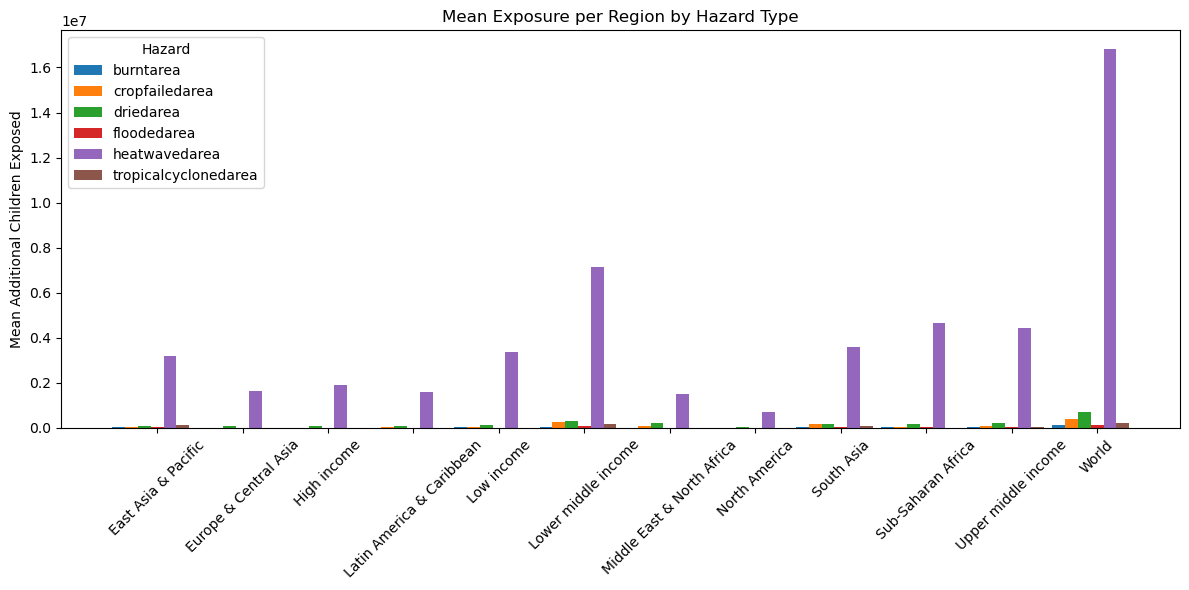

In [65]:
#task11

# figure1 HAZARD-SPECIFIC EXPOSURE PER REGION


df_region_hazard = ds_regions["mean_val"].to_dataframe().reset_index()
regions = df_region_hazard["region"].unique()
hazards = df_region_hazard["extreme"].unique()

plt.figure(figsize=(12,6))
width = 0.15
x = np.arange(len(regions))

for i, hazard in enumerate(hazards):
    vals = [df_region_hazard[(df_region_hazard.region==r) & (df_region_hazard.extreme==hazard)]["mean_val"].values[0] for r in regions]
    plt.bar(x + i*width, vals, width=width, label=hazard)

plt.xticks(x + width*(len(hazards)/2), regions, rotation=45)
plt.ylabel("Mean Additional Children Exposed")
plt.title("Mean Exposure per Region by Hazard Type")
plt.legend(title="Hazard")
plt.tight_layout()
plt.show()


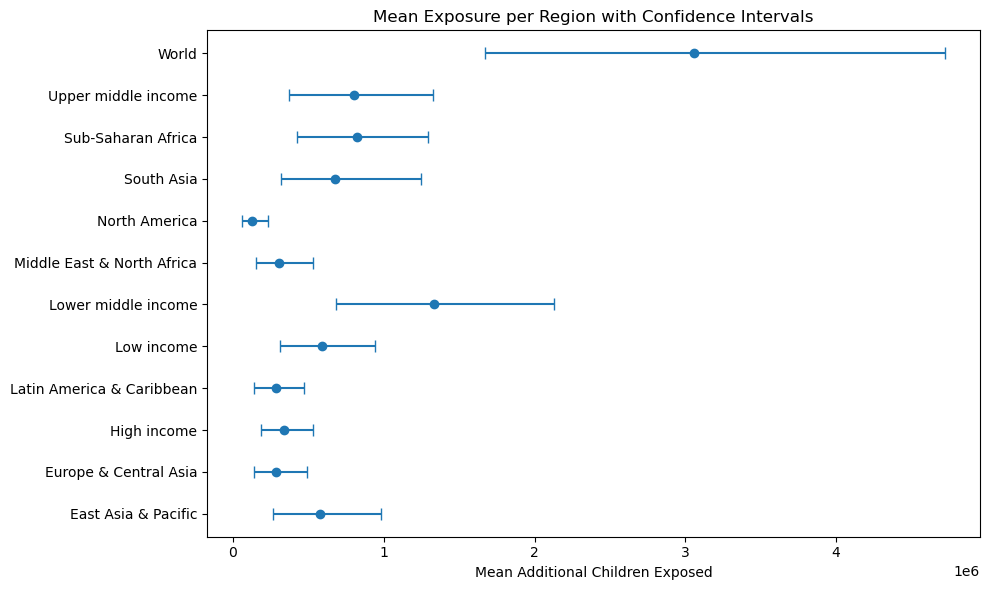

In [66]:
#figure2: Average over hazards
ds_region_ci = ds_regions[["mean_val", "ci_lower", "ci_upper"]].mean(dim=["extreme", "project"])
df_region_ci = ds_region_ci.to_dataframe().reset_index()

plt.figure(figsize=(10,6))

y = np.arange(len(df_region_ci["region"]))
means = df_region_ci["mean_val"]
lower = means - df_region_ci["ci_lower"]
upper = df_region_ci["ci_upper"] - means

plt.errorbar(
    means, y,
    xerr=[lower, upper],
    fmt='o',
    capsize=4
)

plt.yticks(y, df_region_ci["region"])
plt.xlabel("Mean Additional Children Exposed")
plt.title("Mean Exposure per Region with Confidence Intervals")
plt.tight_layout()
plt.show()


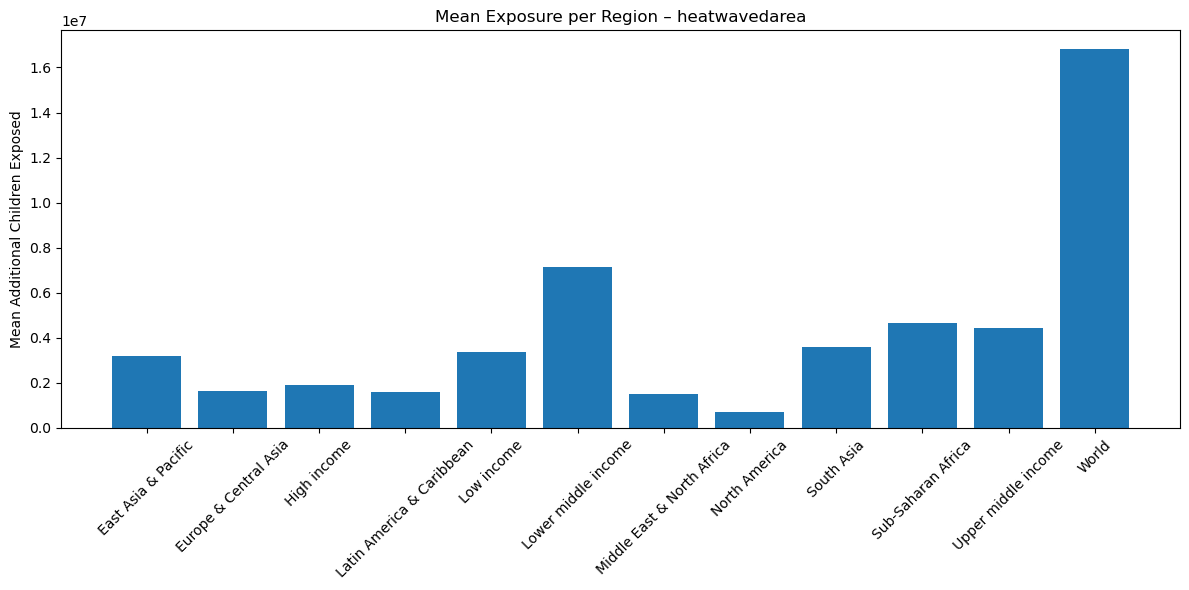

In [72]:
#figure3 since heatwavedarea has the biggest number
selected_hazard = "heatwavedarea"

df_region_hazard = (
    ds_regions["mean_val"]
    .sel(extreme=selected_hazard)
    .mean(dim="project")
    .to_dataframe()
    .reset_index()
)

plt.figure(figsize=(12,6))

plt.bar(
    df_region_hazard["region"],
    df_region_hazard["mean_val"]
)

plt.xticks(rotation=45)
plt.ylabel("Mean Additional Children Exposed")
plt.title(f"Mean Exposure per Region – {selected_hazard}")
plt.tight_layout()
plt.show()


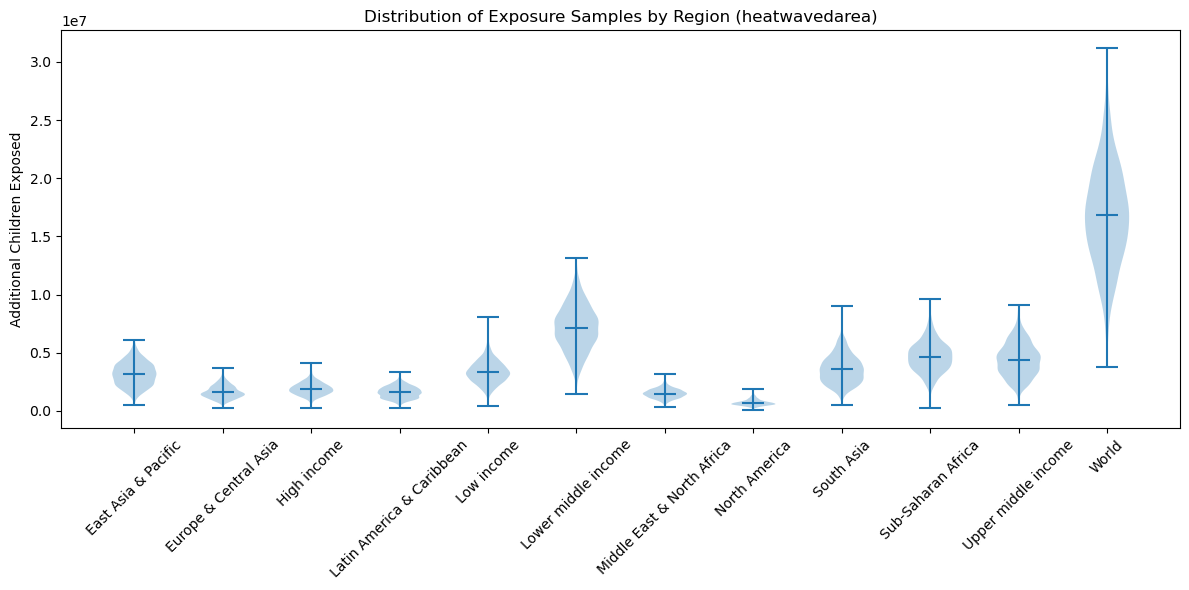

In [75]:
#figure 4
selected_hazard = "heatwavedarea"

# Select samples for one hazard and drop project dimension
ds_samples = (
    ds_regions["S2S_LH_results"]
    .sel(extreme=selected_hazard)
    .mean(dim="project")
)

# Prepare clean data for plotting
plot_data = []
plot_regions = []

for region in ds_samples.region.values:
    vals = ds_samples.sel(region=region).values

    # Remove invalid values
    vals = vals[np.isfinite(vals)]

    # Only keep regions with data
    if vals.size > 0:
        plot_data.append(vals)
        plot_regions.append(region)

# Plot
plt.figure(figsize=(12,6))
plt.violinplot(plot_data, showmeans=True)

plt.xticks(
    np.arange(1, len(plot_regions) + 1),
    plot_regions,
    rotation=45
)

plt.ylabel("Additional Children Exposed")
plt.title("Distribution of Exposure Samples by Region (heatwavedarea)")
plt.tight_layout()
plt.show()
